In [1]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional

[Predicting Sequential Data using LSTM: An Introduction](https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)

In [2]:
def calcW(m, k):
  return np.sqrt(k / m)

def calcTarget(a, b, w, time):
  return a * np.cos(w * time) + b * np.sin(w * time)

def makeTargetSet(a, b, m, k, times): #This is used to find the training time of the prediction
  w = calcW(m, k)
  return np.array(list([time, calcTarget(a, b, w, time)] for time in times)) #This is used to return the value for x(t) after every "time" step till it reaches "times" in seconds.

In this case we are assuming that the mass is vibrating in a **Simple Harmonic Motion**, this means that there is **zero external input forces** acting on this system. 
<br />In other words we can rearange the equation in the following form: $a=-\frac{k}{m}x$, or we can simplify it to this: $a=-{\omega_{n}}^2  x$. 
<br /> $\omega_{n}$ is the **natural frequency** of the object since the acceleration is directly proportional to the displacement in the opposite direction. From this equation, we can derive the natural frequency to be the following: $\omega_{n} = \sqrt\frac{k}{m}$ .

1. **x0:** The inital displacement usually measured in "m"
2. **v0:** The inital velocity usually measured in "m/s" 
2. **k:** The Stiffness Coefficent usually measured in "N/m"
3. **m:** The Mass usually measured in "kg"

To get the maximum Amplitude, you need to do the calculation: $\sqrt(A^2 + B^2)$

Now do note that the equation: $a=-{\omega_{n}}^2  x$ is an **Ordinary Differential Homogeneous Equation**. As a matter of fact we can re-arange our equations to be the following: $\frac{d^{2}x}{dt^{2}}+{\omega_{n}}^2  x = 0$ and if we have the intial conditon of displacement $x(0)=x_{0}$ and the initial condition for velocity $\frac{dx(0)}{dt} = v(0)$, we will get the following equation for the displacement:
<br /> $x(t)=x_{0}cos(\omega_{n}t)+\frac{v_{0}}{\omega_{n}}sin(\omega_{n}t)$

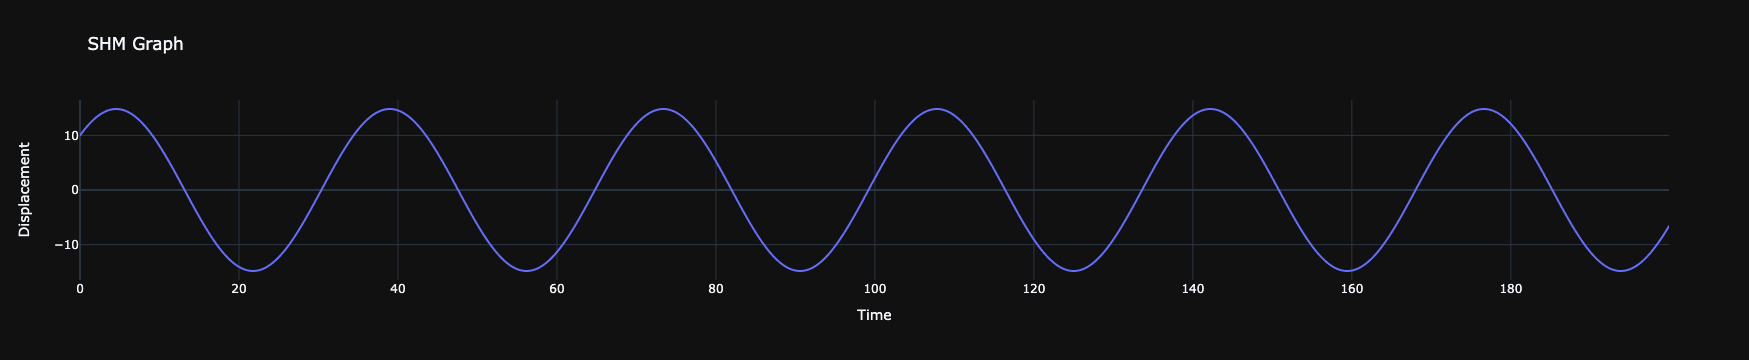

<Figure size 2160x720 with 0 Axes>

In [3]:
xo=10
vo=2
k=3
m=30*k

w=math.sqrt(k/m)
A=xo
B=vo/w

end_time=200
inc=0.1

plt.figure(figsize=(30, 10))
time=np.arange(0,end_time,inc)
data=makeTargetSet(A, B, m, k, time)

d={"Time": data[:,0], "Displacement": data[:,1]}
df = pd.DataFrame(d)

import plotly.express as px
fig = px.line(df, x="Time", y="Displacement", title='SHM Graph', template='plotly_dark')
fig.show()

In [4]:
print(f"Length of full data: {len(df)}")

Length of full data: 2000


In [5]:
df

,Time,Displacement
0,0.0,10.000000
1,0.1,10.198322
2,0.2,10.393245
3,0.3,10.584704
4,0.4,10.772634
...,...,...
1995,199.5,-7.570852
1996,199.6,-7.336736
1997,199.7,-7.100174
1998,199.8,-6.861245


In [6]:
df['Displacement'].max()

14.832389171003992

In [7]:
# time_point=100 #How many samples do you want to train with?
# point=int(time_point/inc)

# train=df[:point]
# test=df[point:]

# plt.figure(figsize=(24, 6))
# plt.plot(train["Time"],train["Displacement"],'g')
# plt.plot(test["Time"],test["Displacement"],'r')

# plt.legend()
# plt.ylabel('Displacement')
# plt.xlabel('Time')

In [8]:
close_data = df['Displacement'].values
close_data = close_data.reshape((-1,1))

split_percent= 80
split_percent = split_percent/100
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Time'][:split]
date_test = df['Time'][split:]

print(f"Number of training samples: {len(close_train)}")
print(f"Number of predicting samples: {len(close_test)}")

Number of training samples: 1600
Number of predicting samples: 400


The "[TimeseriesGenerator](https://keras.io/api/preprocessing/timeseries/)" function accepts a sequence of data points collected at equal intervals, as well as time-series characteristics such as sequence/window length, spacing between two sequences/windows, and so on, to generate batches of time-series inputs and targets.

In [27]:
look_back = 30 # We could change to 60

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20) #change the batch size     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [28]:
print(train_generator[0][1].shape)
print(test_generator[0][1].shape)

(20,)
(1,)


# Creating the Neural Network

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 1s 5ms/step - loss: 25.3262
Epoch 2/50
79/79 [==============================] - 0s 5ms/step - loss: 5.5725
Epoch 3/50
79/79 [==============================] - 0s 5ms/step - loss: 28.3282
Epoch 4/50
79/79 [==============================] - 0s 5ms/step - loss: 7.8288
Epoch 5/50
79/79 [==============================] - 0s 5ms/step - loss: 3.6079
Epoch 6/50
79/79 [==============================]

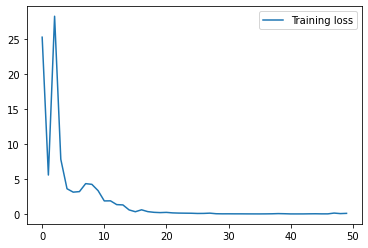

In [30]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.summary()

num_epochs = 50
history=model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

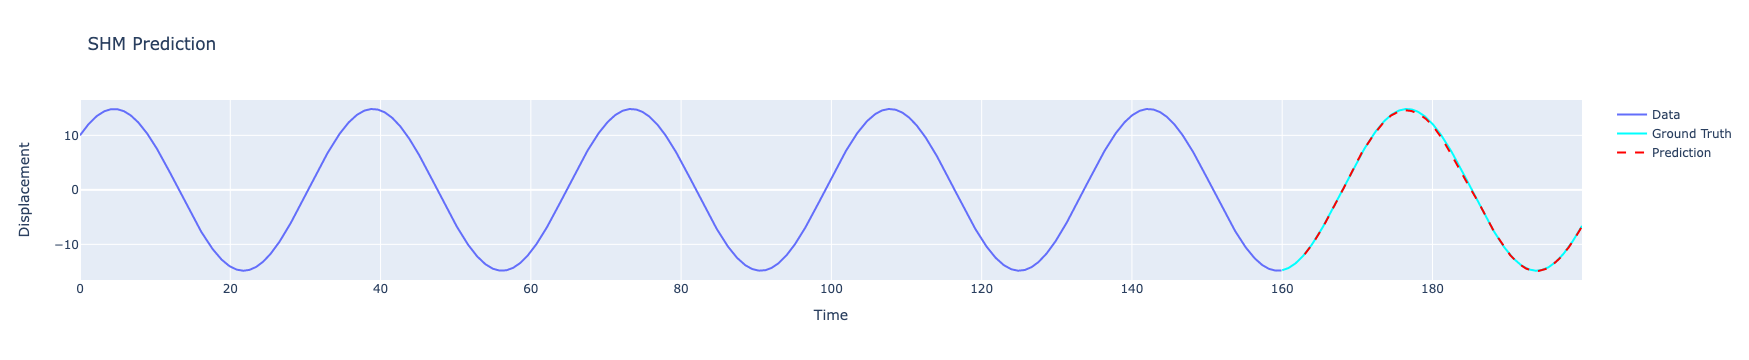

In [31]:
date_pred = date_test[look_back:]
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = close_test,
    #mode='lines',
    name = 'Ground Truth',
    line=dict(color='cyan', width=2)
)

trace3 = go.Scatter(
    x = date_pred,
    y = prediction,
    #mode = 'lines',
    name = 'Prediction',
    line=dict(color='red', width=2, dash='dash')
)
layout = go.Layout(
    title = "SHM Prediction",
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "Displacement"}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [32]:
print(f"Prediction Shape: {prediction.shape}")

Prediction Shape: (370,)


1. **"close_train"** is the data set used for the training using a certain percentage to split the dataset
2. **"prediction"** speaks for itself, it is basicaly predicting what will happen on the testing data
3. **"close_test"** is the data set used for the testing using the remaining percentage to compare with the prediction, also known as the "Ground Truth"

# Forecasting

In [33]:
close_data = close_data.reshape((-1))

In [34]:
close_data.shape

(2000,)

In [35]:
def predict(num_prediction, model):
    prediction_list = close_train[-(look_back):]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [36]:
def predict_dates(num_prediction):
    prediction_dates = df['Time'][len(close_train)+1:len(close_train)+num_prediction+1] 
    return prediction_dates
    
# def predict_dates(num_prediction):
#     last_date = df['Time'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

In [37]:
num_prediction = len(close_test)-1
print(f"Number for predictions: {num_prediction}")

Number for predictions: 399


In [38]:
print("Forecast")
forecast = predict(num_prediction, model)
print(forecast)

Forecast
1/1 [==============================] - 0s 10ms/step
[-1.47745290e+01 -1.47991915e+01 -1.47862358e+01 -1.47719946e+01
 -1.47560549e+01 -1.47378244e+01 -1.47172604e+01 -1.46944103e+01
 -1.46693163e+01 -1.46419897e+01 -1.46123800e+01 -1.45804281e+01
 -1.45457363e+01 -1.45086708e+01 -1.44691925e+01 -1.44272661e+01
 -1.43828821e+01 -1.43360338e+01 -1.42867079e+01 -1.42349062e+01
 -1.41806307e+01 -1.41238937e+01 -1.40647039e+01 -1.40030298e+01
 -1.39388409e+01 -1.38721600e+01 -1.38029814e+01 -1.37312946e+01
 -1.36571121e+01 -1.35804205e+01 -1.35012331e+01 -1.34195518e+01
 -1.33353853e+01 -1.32487259e+01 -1.31595869e+01 -1.30679712e+01
 -1.29738903e+01 -1.28773537e+01 -1.27783756e+01 -1.26769619e+01
 -1.25731306e+01 -1.24668961e+01 -1.23582754e+01 -1.22472839e+01
 -1.21339474e+01 -1.20182781e+01 -1.19002981e+01 -1.17800322e+01
 -1.16575117e+01 -1.15327959e+01 -1.14058800e+01 -1.12767849e+01
 -1.11455393e+01 -1.10121613e+01 -1.08766775e+01 -1.07391052e+01
 -1.05994673e+01 -1.04577732e

In [39]:
forecast


array([-1.47745290e+01, -1.47991915e+01, -1.47862358e+01, -1.47719946e+01,
       -1.47560549e+01, -1.47378244e+01, -1.47172604e+01, -1.46944103e+01,
       -1.46693163e+01, -1.46419897e+01, -1.46123800e+01, -1.45804281e+01,
       -1.45457363e+01, -1.45086708e+01, -1.44691925e+01, -1.44272661e+01,
       -1.43828821e+01, -1.43360338e+01, -1.42867079e+01, -1.42349062e+01,
       -1.41806307e+01, -1.41238937e+01, -1.40647039e+01, -1.40030298e+01,
       -1.39388409e+01, -1.38721600e+01, -1.38029814e+01, -1.37312946e+01,
       -1.36571121e+01, -1.35804205e+01, -1.35012331e+01, -1.34195518e+01,
       -1.33353853e+01, -1.32487259e+01, -1.31595869e+01, -1.30679712e+01,
       -1.29738903e+01, -1.28773537e+01, -1.27783756e+01, -1.26769619e+01,
       -1.25731306e+01, -1.24668961e+01, -1.23582754e+01, -1.22472839e+01,
       -1.21339474e+01, -1.20182781e+01, -1.19002981e+01, -1.17800322e+01,
       -1.16575117e+01, -1.15327959e+01, -1.14058800e+01, -1.12767849e+01,
       -1.11455393e+01, -

In [40]:
print("Forecast Dates")
forecast_dates = predict_dates(num_prediction)
print(forecast_dates)

Forecast Dates
1601    160.1
1602    160.2
1603    160.3
1604    160.4
1605    160.5
        ...  
1995    199.5
1996    199.6
1997    199.7
1998    199.8
1999    199.9
Name: Time, Length: 399, dtype: float64


In [41]:
# def predict_dates(num_prediction):
#     prediction_dates = df['Time'][len(close_train)+1:len(close_train)+num_prediction+1] 
#     return prediction_dates

# predict_dates(5)

In [42]:
# df['Time'].values[-400]

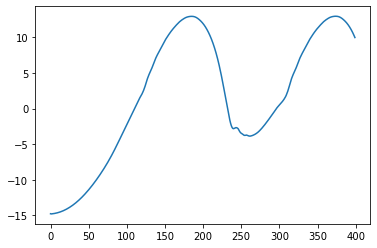

In [43]:
plt.plot(forecast)

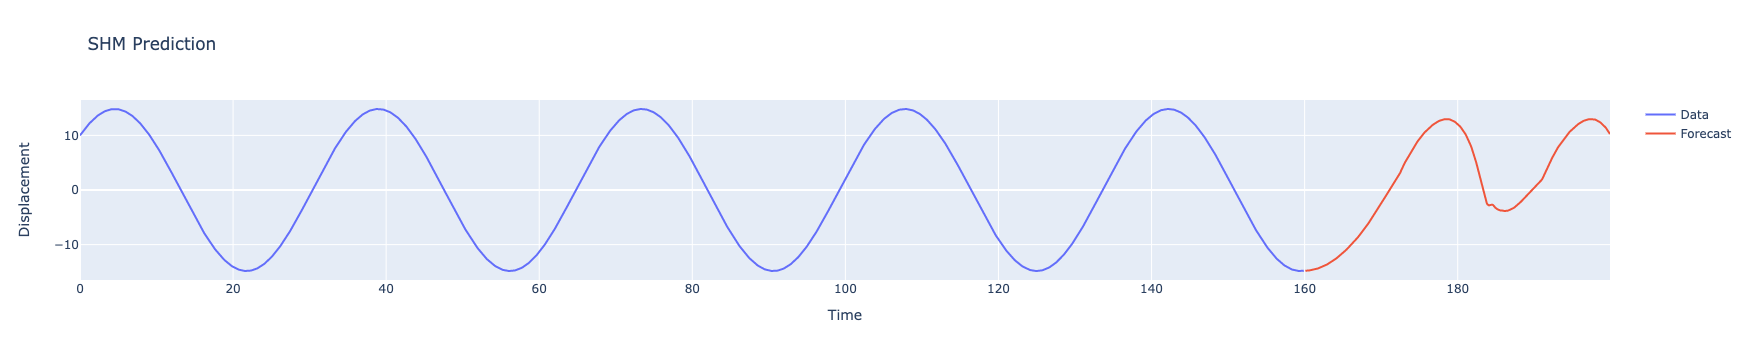

In [44]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)

trace3 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecast'
)

layout = go.Layout(
    title = "SHM Prediction",
    xaxis = {'title' : "Time"},
    yaxis = {'title' : "Displacement"}
)
fig = go.Figure(data=[trace1, trace3], layout=layout)
fig.show()

This prediction behavior is normal because of the propogation from the small error in the begining to propogate into a larger error during the forecast phase